In [2]:
import cloudpickle as pickle
import numpy as np
import math

In [3]:
# upload data
def unpickle(filename):
    with open (filename,'rb') as fp:
        d1 = pickle.load(fp)
    return d1

In [4]:
d1 = unpickle('batch_1.pickle')
print('Size of one data batch:', d1['data'].shape, d1['labels'].shape)
total_data_batch = 2
for i in range(2,total_data_batch + 1):
    new_batch = unpickle('batch_'+str(i)+'.pickle')
    d1['data']  = np.concatenate((d1['data'], new_batch['data']), axis=0)
    d1['labels'] = np.concatenate((d1['labels'], new_batch['labels']), axis=0)

Size of one data batch: (5000, 196608) (5000, 1)


KeyboardInterrupt: 

In [164]:
print('Total data size after merge:', d1['data'].shape, d1['labels'].shape)

<class 'numpy.ndarray'>


In [149]:
# split training, val, test set
total_count = d1['data'].shape[0]
train_count = math.ceil(total_count * 0.7)
val_count = math.ceil((total_count - training_count) * 0.5)
test_count = total_count - train_count - val_count
print(total_count, train_count, val_count, test_count)
X_all = np.array(d1['data']).reshape(total_count,3,256,256)
y_all = np.array(d1['labels']).astype(int).reshape(total_count) # each label is a np int64 obj
X_train = X_all[:train_count]
y_train = y_all[:train_count]
X_val = X_all[train_count:(train_count+val_count)]
y_val = y_all[train_count:(train_count+val_count)]
X_test = X_all[(train_count+val_count):(train_count+val_count+test_count)]
y_test = y_all[(train_count+val_count):(train_count+val_count+test_count)]

In [150]:
X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, type(y_test[1])

((5000, 3, 256, 256),
 (5000,),
 (1000, 3, 256, 256),
 (1000,),
 (125, 3, 256, 256),
 (125,),
 (125, 3, 256, 256),
 (125,),
 numpy.int64)

In [151]:
# normalize RGB data
X_train_normalized = X_train/255.0 
X_val_normalized =  X_val/255.0
X_test_normalized = X_test/255.0
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1000, 3, 256, 256),
 (1000,),
 (125, 3, 256, 256),
 (125,),
 (125, 3, 256, 256),
 (125,))

In [31]:
CLASSES = ['No DR', 'Mild','Moderate','Severe','Proliferative DR']

def index_to_class_name(y):
    return CLASSES[int(y)]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)

In [101]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

SCALE = 1
dpi = 80
IMG_SIZE = 256
height, width = IMG_SIZE, IMG_SIZE
figsize = (width/float(dpi))/SCALE, (height/float(dpi))/SCALE

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,256,256,3)
    img = data.reshape(256,256,3)
    imgplot = plt.imshow(img, cmap = 'gray')
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig=plt.figure(figsize=(10, 10))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n/columns)
    for i in range(n):
        img = data[i].reshape(256,256,3)
        ax = fig.add_subplot(rows, columns, i+1) ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i])+": "+class_name)
        plt.imshow(img, cmap = 'gray')
    plt.show()

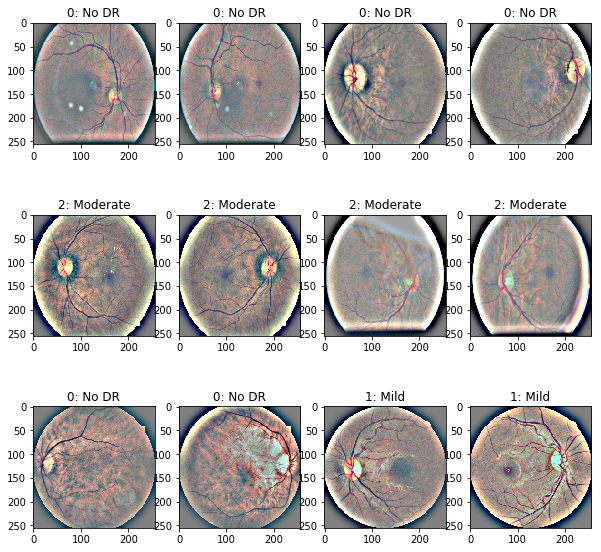

In [102]:
show_multiple_images(X_train, y_train)

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

# torch.nn.Cov2d(input image channel, output channel, x: x*x square convolution kernel(filter)，stride =1, padding = 1)
# default padding is 0
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,2,1)
        self.conv2 = nn.Conv2d(6,16,3,1,1)
        
        self.fc1 = nn.Linear(16*32*32, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,5)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.reshape(x.shape[0], -1)
#         softmax = nn.Softmax(dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [157]:
n_iteration = 40
batch_size = 128

# prepare for mini-batch stochastic gradient descent
n_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = Tensor(X_train_normalized).reshape(train_count, -1)
X_val_tensor = Tensor(X_val_normalized).reshape(val_count,-1)

# convert training label to tensor and to type long
y_train_tensor = Tensor(y_train).long()
y_val_tensor = Tensor(y_val).long()

print('X train tensor shape:', X_train_tensor.shape)

X train tensor shape: torch.Size([1000, 196608])


In [159]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)
# init optimizer
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)
# set loss function
# weight = torch.FloatTensor([0.5, 2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()

model structure:  ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


In [161]:
## start 
def get_number_correct(pred, label):
    # find the largest number and return the index of that num
    pred_number = torch.argmax(pred,dim=1)
    res = (pred_number == label).long().sum()
#     print(pred_number, label)
    return res

train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    running_loss = 0
    correct_train = 0
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:(batch_start_index+batch_size)]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:(batch_start_index+batch_size)]
        
        pred = conv_net(X_batch.reshape(-1, 3, 256, 256))
        loss = criterion(pred, y_batch)
        running_loss += loss.item()
        correct_train += get_number_correct(pred, y_batch)
        # update 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= n_batch
    pred_val = conv_net(X_val_tensor.reshape(-1, 3, 256, 256))
    loss_val = criterion(pred_val, y_val_tensor).item()
    train_acc = correct_train/float(train_count)
    val_acc =  get_number_correct(pred_val, y_val_tensor)/float(val_count)
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %( i,running_loss, train_acc, loss_val, val_acc)) 
#     i ,ave_train_loss, train_accu, val_loss, val_accu
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = running_loss
    train_accu_list[i] = train_acc
    val_loss_list[i] = loss_val
    val_accu_list[i] = val_acc  

Iter 0 ,Train loss: 0.832, Train acc: 0.753, Val loss: 0.876, Val acc: 0.736
Iter 1 ,Train loss: 0.821, Train acc: 0.753, Val loss: 0.875, Val acc: 0.736
Iter 2 ,Train loss: 0.814, Train acc: 0.753, Val loss: 0.872, Val acc: 0.736
Iter 3 ,Train loss: 0.804, Train acc: 0.753, Val loss: 0.869, Val acc: 0.736
Iter 4 ,Train loss: 0.792, Train acc: 0.753, Val loss: 0.870, Val acc: 0.736
Iter 5 ,Train loss: 0.779, Train acc: 0.753, Val loss: 0.872, Val acc: 0.736
Iter 6 ,Train loss: 0.765, Train acc: 0.753, Val loss: 0.873, Val acc: 0.736
Iter 7 ,Train loss: 0.750, Train acc: 0.753, Val loss: 0.872, Val acc: 0.736
Iter 8 ,Train loss: 0.729, Train acc: 0.755, Val loss: 0.877, Val acc: 0.736
Iter 9 ,Train loss: 0.701, Train acc: 0.757, Val loss: 0.893, Val acc: 0.736
Iter 10 ,Train loss: 0.668, Train acc: 0.757, Val loss: 0.898, Val acc: 0.736
Iter 11 ,Train loss: 0.632, Train acc: 0.764, Val loss: 0.910, Val acc: 0.736
Iter 12 ,Train loss: 0.589, Train acc: 0.772, Val loss: 0.933, Val acc: 0.

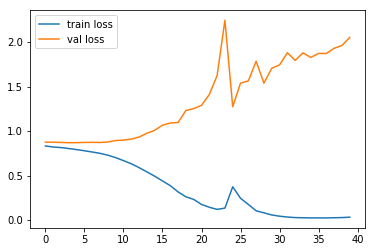

In [162]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

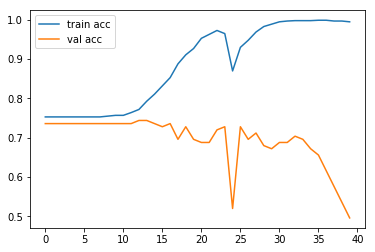

In [163]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()